In [ ]:
import os
import os.path as osp
from typing import Any, Dict, Optional
import pickle
import pandas as pd
import torch
from torch.nn import (
    BatchNorm1d,
    Embedding,
    Linear,
    ModuleList,
    ReLU,
    Sequential,
    )
from typing import Any, List, Dict, Optional, Union
from torch_geometric.typing import (
    Adj,
    OptPairTensor,
    OptTensor,
    Size,
)
import torch
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import numpy as np
import networkx as nx
import math

from torch.nn.functional import linear
import torch_geometric.transforms as T
from torch_geometric.datasets import ZINC
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINEConv, GPSConv, global_add_pool
from torch_geometric.nn.attention import PerformerAttention

print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("torch cuda:", torch.version.cuda)
print("gpus:", torch.cuda.device_count())
print("gpu name:", torch.cuda.get_device_name(0))

attn_type = 'multihead'  # change to 'performer' to try PerformerAttention

# Resolve data dir relative to this notebook/workspace
path = osp.join(os.getcwd(), 'data', 'ZINC-PE')

transform = T.AddRandomWalkPE(walk_length=20, attr_name='pe')
train_dataset = ZINC(path, subset=True, split='train', pre_transform=transform)
val_dataset = ZINC(path, subset=True, split='val', pre_transform=transform)
test_dataset = ZINC(path, subset=True, split='test', pre_transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

torch: 2.5.1+cu121
cuda available: True
torch cuda: 12.1
gpus: 1
gpu name: NVIDIA RTX 2000 Ada Generation Laptop GPU


## Structure of the Data

**Each molecule is represented by four main entities:**
1. The atoms in the molecule
2. The adjacency matrix describing which atoms are bound to each other
3. The logP_SA_cycle_normalized $^{*}$ score

These are stored in the dataloader as:
  * `x`: Numerical representations of the atoms in the molecule
    * 'C'= 0, 'O'= 1, 'N'= 2, 'F'= 3, etc.
    * These can be seen in `atom_dict.word2idx`
  * `edge_index`: Positions of each bond in the atom-to-atom square adjacency matrix.
  * `edge_attr`: Type of bond at each position in `edge_index`. 
    * 1 = single bond, 2 = double bond, 3 = triple bond, 4 = aromatic ring bond
  * `y`: The logP_SA_cycle_normalized score for the molecule


**logP_SA_cycle_normalized:** composite molecular score of:
  - logP: hydrophobicity / lipophilicity (low = hydrophilic, high = lipophilic)
  - SA: synthetic accesibility (how easy the molecule is to make)
  - Cycle Penalty: Discourages large or complex ring systems

## Function for Drawing Molecules

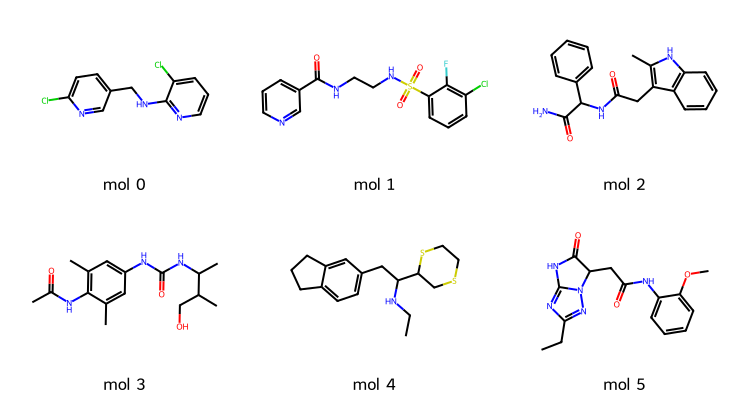

In [62]:
class Dictionary: 
    def __init__(self): 
        self.word2idx = {} 
        self.idx2word = [] 
        self.word2num_occurence = {} 
        self.idx2num_occurence = [] 
    
with open(osp.join(path, 'raw/atom_dict.pickle'), 'rb') as f: 
    atom_dict = pickle.load(f) 
    
def draw_molecules_from_adj_and_features(test_loader, mol_indices: List[int], mols_per_row: int = 3) -> Any:
    bond_map = {
        1: Chem.BondType.SINGLE,
        2: Chem.BondType.DOUBLE,
        3: Chem.BondType.TRIPLE,
        4: Chem.BondType.AROMATIC,
    }

    mols: List[Chem.Mol] = []
    legends: List[str] = []

    for mol_index in mol_indices:
        data = test_loader.dataset[mol_index]

        atom_type = data.x.view(-1)
        num_nodes = int(atom_type.numel())

        edge_index = data.edge_index
        edge_attr  = data.edge_attr

        # Recreate the dense adjacency matrix of atom-atom bonds
        adj_dense = torch.zeros((num_nodes, num_nodes), dtype=edge_attr.dtype, device=edge_attr.device)
        adj_dense[edge_index[0], edge_index[1]] = edge_attr
        A = adj_dense.detach().cpu().numpy()

        # Convert the numerical atom types back to their string labels
        atom_to_word = [atom_dict.idx2word[int(i)] for i in atom_type.detach().cpu().numpy()]

        # Build RDKit molecule from adjacency matrix and atom labels
        rw = Chem.RWMol()
        for lbl in atom_to_word:
            rw.AddAtom(Chem.Atom(lbl.split()[0]))

        for i in range(num_nodes):
            for j in range(i + 1, num_nodes):
                bt = int(A[i, j])
                if bt != 0:
                    rw.AddBond(i, j, bond_map.get(bt, Chem.BondType.SINGLE))

        m = rw.GetMol()
        Chem.SanitizeMol(m, catchErrors=True)
        AllChem.Compute2DCoords(m)

        mols.append(m)
        legends.append(f"mol {mol_index}")

    # Draw each molecule and arrange them in a grid
    img = Draw.MolsToGridImage(
        mols,
        molsPerRow=mols_per_row,
        subImgSize=(250, 200),
        legends=legends,
        useSVG=False,
    )
    return img

img = draw_molecules_from_adj_and_features(test_loader, mol_indices=[0, 1, 2, 3, 4, 5], mols_per_row=3)
img


## Model Architecture

### MultiHeadAttention Class

Simplified PyTorch MultiHeadAttention class so that it's easier to see what all is happening under the hood

In [ ]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, num_heads: int, embed_dim: int):
        super().__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        
        self.q_proj_weight = torch.nn.Parameter(torch.empty((embed_dim, embed_dim)))
        self.k_proj_weight = torch.nn.Parameter(torch.empty((embed_dim, embed_dim)))
        self.v_proj_weight = torch.nn.Parameter(torch.empty((embed_dim, embed_dim)))
        
        self.out_proj = torch.nn.Linear(embed_dim, embed_dim)
        
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == self.embed_dim, "embed_dim must be divisible by num_heads"
    
    def forward(self, query, key, value):
        tgt_len, bsz, embed_dim = query.shape
        src_len, _, _ = key.shape
        
        # Project the query, key, and value tensors
        q = linear(query, self.q_proj_weight)
        k = linear(key, self.k_proj_weight)
        v = linear(value, self.v_proj_weight)
        
        # Split into multiple heads and put the batch size first, sequence length second, and head dim last        
        q = q.view(bsz, self.num_heads, tgt_len, self.head_dim)
        k = k.view(bsz, self.num_heads, src_len, self.head_dim)
        v = v.view(bsz, self.num_heads, src_len, self.head_dim)

        # Scale attention weights by the square root of the query dimension
        scale_factor = 1 / math.sqrt(query.size(-1))
        
        # Compute the Query and Key dot product attention scores
        attn_weight = q @ k.transpose(-2, -1) * scale_factor
        
        # Apply softmax to get attention weights
        attn_weight = torch.softmax(attn_weight, dim=-1)
        
        # Muliply the attention weights with the Value vectors to get the final output
        attn_output = attn_weight @ v        
        
        # Concatenate multiple heads and put the sequence length first, batch size second, and head dim last
        attn_output = (
            attn_output.permute(2, 0, 1, 3).contiguous().view(bsz * tgt_len, embed_dim)
        )

        # Final linear projection
        attn_output = linear(attn_output, self.out_proj.weight, self.out_proj.bias)
        
        attn_output = attn_output.view(tgt_len, bsz, attn_output.size(1))
        
        return attn_output

### GINEConv Message Passing Convolutional GNN

From the ["Strategies for Pre-training Graph Neural Networks"](https://arxiv.org/abs/1905.12265) paper.

In [ ]:
from torch_geometric.nn import MessagePassing

class GINEConv(MessagePassing):
    def __init__(self, nn: torch.nn.Module):
        super().__init__()
        self.aggr = "add"
        self.nn = nn
        self.eps = 0.0
    
    def forward(
        self,
        x: Union[torch.Tensor, OptPairTensor],
        edge_index: Adj,
        edge_attr: OptTensor = None,
        size: Size = None,
    ) -> torch.Tensor:

        if isinstance(x, torch.Tensor):
            x = (x, x)

        # propagate_type: (x: OptPairTensor, edge_attr: OptTensor)
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr, size=size)

        x_r = x[1]
        if x_r is not None:
            out = out + (1 + self.eps) * x_r

        return self.nn(out)

    def message(self, x_j: torch.Tensor, edge_attr: torch.Tensor) -> torch.Tensor:
        if self.lin is None and x_j.size(-1) != edge_attr.size(-1):
            raise ValueError("Node and edge feature dimensionalities do not "
                             "match. Consider setting the 'edge_dim' "
                             "attribute of 'GINEConv'")

        if self.lin is not None:
            edge_attr = self.lin(edge_attr)

        return (x_j + edge_attr).relu()

### Graph Transformer Model

From the ["Recipe for a General, Powerful, Scalable Graph Transformer"](https://arxiv.org/abs/2205.12454) paper.

In [ ]:
class GPS(torch.nn.Module):
    def __init__(self, channels: int, pe_dim: int, num_layers: int,
                 attn_type: str, attn_kwargs: Dict[str, Any]):
        super().__init__()

        self.node_emb = Embedding(28, channels - pe_dim)
        self.pos_encoder_lin = Linear(20, pe_dim)
        self.pos_encoder_norm = BatchNorm1d(20)
        self.edge_emb = Embedding(4, channels)

        self.convs = ModuleList()
        for _ in range(num_layers):
            nn = Sequential(
                Linear(channels, channels),
                ReLU(),
                Linear(channels, channels),
            )
            
            conv = GPSConv(channels, GINEConv(nn), heads=4,
                           attn_type=attn_type, attn_kwargs=attn_kwargs)
            self.convs.append(conv)


        self.mlp = Sequential(
            Linear(channels, channels // 2),
            ReLU(),
            Linear(channels // 2, channels // 4),
            ReLU(),
            Linear(channels // 4, 1),
        )
        self.redraw_projection = RedrawProjection(
            self.convs,
            redraw_interval=1000 if attn_type == 'performer' else None)


    def forward(self, x, pe, edge_index, edge_attr, batch):
        x_pe = self.pe_norm(pe)
        x = torch.cat((self.node_emb(x.squeeze(-1)), self.pos_encoder_lin(x_pe)), 1)
        edge_attr = self.edge_emb(edge_attr)


        for conv in self.convs:
            x = conv(x, edge_index, batch, edge_attr=edge_attr)
        x = global_add_pool(x, batch)
        return self.mlp(x)

class RedrawProjection:
    def __init__(self, model: torch.nn.Module,
                 redraw_interval: Optional[int] = None):
        self.model = model
        self.redraw_interval = redraw_interval
        self.num_last_redraw = 0


    def redraw_projections(self):
        if not self.model.training or self.redraw_interval is None:
            return
        if self.num_last_redraw >= self.redraw_interval:
            fast_attentions = [
                module for module in self.model.modules()
                if isinstance(module, PerformerAttention)
            ]
            for fast_attention in fast_attentions:
                fast_attention.redraw_projection_matrix()
            self.num_last_redraw = 0
            return
        self.num_last_redraw += 1

## Training

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
attn_kwargs = {'dropout': 0.5}
model = GPS(channels=64, pe_dim=8, num_layers=10, attn_type=attn_type,
            attn_kwargs=attn_kwargs).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20,
                              min_lr=0.00001)

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        model.redraw_projection.redraw_projections()
        out = model(data.x, data.pe, data.edge_index, data.edge_attr,
                    data.batch)
        loss = (out.squeeze() - data.y).abs().mean()
        loss.backward()
        total_loss += loss.item() * data.num_graphs
        optimizer.step()
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(loader):
    model.eval()
    total_error = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.pe, data.edge_index, data.edge_attr,
                    data.batch)
        total_error += (out.squeeze() - data.y).abs().sum().item()
    return total_error / len(loader.dataset)

for epoch in range(1, 10):
    loss = train()
    val_mae = test(val_loader)
    test_mae = test(test_loader)
    scheduler.step(val_mae)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Val: {val_mae:.4f}, '
          f'Test: {test_mae:.4f}')

Using device: cuda
Epoch: 01, Loss: 0.6812, Val: 0.5119, Test: 0.5234
Epoch: 02, Loss: 0.5512, Val: 0.4775, Test: 0.4433
Epoch: 03, Loss: 0.5010, Val: 0.4364, Test: 0.4302
Epoch: 04, Loss: 0.4471, Val: 0.4192, Test: 0.3771
Epoch: 05, Loss: 0.4268, Val: 0.4241, Test: 0.4289
Epoch: 06, Loss: 0.4370, Val: 0.4459, Test: 0.4224
Epoch: 07, Loss: 0.4074, Val: 0.6241, Test: 0.6114
Epoch: 08, Loss: 0.3949, Val: 0.3211, Test: 0.3005
Epoch: 09, Loss: 0.3673, Val: 0.3509, Test: 0.3217


[13:16:02] Explicit valence for atom # 8 N, 4, is greater than permitted


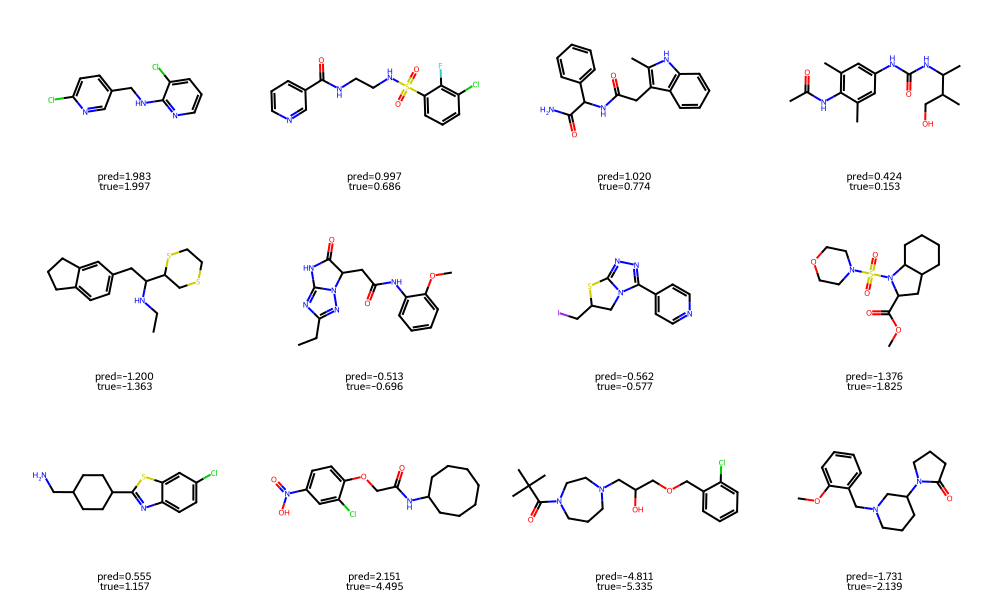

In [47]:
import torch
from rdkit import Chem
from rdkit.Chem import AllChem, Draw

bond_map = {
    1: Chem.BondType.SINGLE,
    2: Chem.BondType.DOUBLE,
    3: Chem.BondType.TRIPLE,
    4: Chem.BondType.AROMATIC,
}

def data_to_rdkit_mol(data, atom_dict):
    x = data.x.view(-1).detach().cpu().numpy()
    n = len(x)

    edge_index = data.edge_index.detach().cpu()
    edge_attr  = data.edge_attr.detach().cpu()

    # dense bond type adj
    A = torch.zeros((n, n), dtype=edge_attr.dtype)
    A[edge_index[0], edge_index[1]] = edge_attr
    A = A.numpy()

    atom_labels = [atom_dict.idx2word[int(i)] for i in x]

    rw = Chem.RWMol()
    for lbl in atom_labels:
        rw.AddAtom(Chem.Atom(lbl.split()[0]))

    for i in range(n):
        for j in range(i + 1, n):
            bt = int(A[i, j])
            if bt != 0:
                rw.AddBond(i, j, bond_map.get(bt, Chem.BondType.SINGLE))

    m = rw.GetMol()
    Chem.SanitizeMol(m, catchErrors=True)
    AllChem.Compute2DCoords(m)
    return m


@torch.no_grad()
def predict_and_draw_grid(model, loader, atom_dict, device, n_show=12, mols_per_row=4):
    model.eval()

    mols = []
    legends = []

    shown = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.pe, data.edge_index, data.edge_attr, data.batch).squeeze()

        # split batched graphs back into individual Data objects
        data_list = data.to_data_list()
        out_list = out.detach().cpu().tolist()
        y_list = data.y.detach().cpu().view(-1).tolist()

        for g, pred, y in zip(data_list, out_list, y_list):
            m = data_to_rdkit_mol(g, atom_dict)
            mols.append(m)
            legends.append(f"pred={pred:.3f}\ntrue={y:.3f}")
            shown += 1
            if shown >= n_show:
                break
        if shown >= n_show:
            break

    return Draw.MolsToGridImage(
        mols,
        molsPerRow=mols_per_row,
        subImgSize=(250, 200),
        legends=legends,
        useSVG=False,
    )

img = predict_and_draw_grid(model, test_loader, atom_dict, device, n_show=12, mols_per_row=4)
img
